<a href="https://colab.research.google.com/github/paarthbamb/dataScience/blob/main/PaarBambUnit4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unit 4 Project**
by Paarth Bamb

In [2]:
!pip install preliz --quiet

import preliz as pz
import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompatible.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompatible.


**Part 1: Introduction**

For my Unit 4 project, I’m analyzing how NFL teams perform against the betting spread using two different modeling approaches: a hierarchical model and a non-hierarchical one. The goal is to predict the likelihood that a team covers the spread in a given week based on factors like the point spread itself and whether the team is playing at home or away.

I’ll be focusing on the four teams in the NFC North (the Lions, Packers, Bears, and Vikings) to see how their performances differ and whether certain teams consistently beat expectations. The hierarchical model, in particular, lets me see if accounting for team-level differences provides a better explanation of how often each team covers the spread.

Ultimately, I want to understand whether including this “team-level structure” gives us a clearer picture of NFL betting outcomes compared to treating all teams as if they behave the same.

**Part 2: Data**

I collected NFL game data for the four teams this season, including the week, opponent, spread, home/away, and cover (whether the team beat the spread).


*   cover (0/1) is our outcome variable: did the team cover the spread?
*  spread and home_away are predictors: they may influence the probability of covering.

The data is stored in a CSV, which I loaded using Pandas:

In [3]:
nfl_data = pd.read_csv('https://raw.githubusercontent.com/paarthbamb/nflData/refs/heads/main/NFC_North_Spreads_Big.csv')
nfl_data

,week,team,opponent,spread,home_away,cover
0,1,Lions,Ravens,-6.6,Home,1
1,2,Lions,49ers,9.8,Away,1
2,3,Lions,Chiefs,-13.4,Home,1
3,4,Lions,Packers,-0.2,Home,0
4,5,Lions,Bears,-4.6,Home,1
...,...,...,...,...,...,...
63,13,Vikings,Lions,11.6,Home,1
64,14,Vikings,Eagles,6.6,Home,0
65,15,Vikings,Buccaneers,8.9,Home,1
66,16,Vikings,Cowboys,-9.3,Away,1


We can also encode teams as categorical indices for modeling:

In [4]:
team_encode = pd.Categorical(nfl_data['team'])
team_index = team_encode.codes
team_coords = {"teams": team_encode.categories}

print(team_coords)
print(team_encode)
print(team_index)


{'teams': Index(['Bears', 'Lions', 'Packers', 'Vikings'], dtype='object')}
['Lions', 'Lions', 'Lions', 'Lions', 'Lions', ..., 'Vikings', 'Vikings', 'Vikings', 'Vikings', 'Vikings']
Length: 68
Categories (4, object): ['Bears', 'Lions', 'Packers', 'Vikings']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


**Part III: Nonhierarchical Models**

Baseline nonhierarchical model

We start by assuming all teams are independent and have their own probabilities of covering the spread, without any shared information.

In [5]:
with pm.Model(coords=team_coords) as nfl_model_nh:


    alpha = pm.HalfNormal('alpha', sigma=5, dims="teams")
    beta = pm.HalfNormal('beta', sigma=5, dims="teams")

    p_mean_team = pm.Deterministic('p_mean_team', alpha / (alpha + beta), dims="teams")

    # p is still defined per observation/game for the likelihood
    p = pm.Beta('p', alpha=alpha[team_index], beta=beta[team_index])
    y = pm.Bernoulli('y', p=p, observed=nfl_data["cover"])

    idata_nh = pm.sample(target_accept=0.95, tune=2000)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y'>

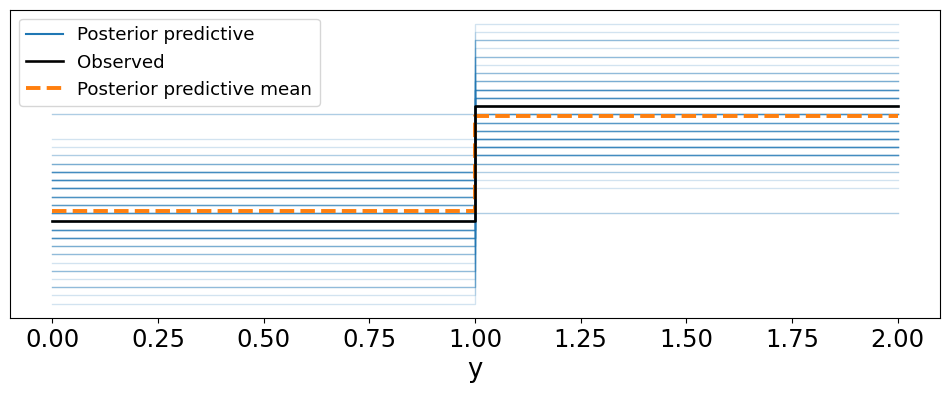

In [6]:
pm.sample_posterior_predictive(idata_nh, model=nfl_model_nh, extend_inferencedata=True)
az.plot_ppc(idata_nh, num_pp_samples=100, figsize=(12, 4))


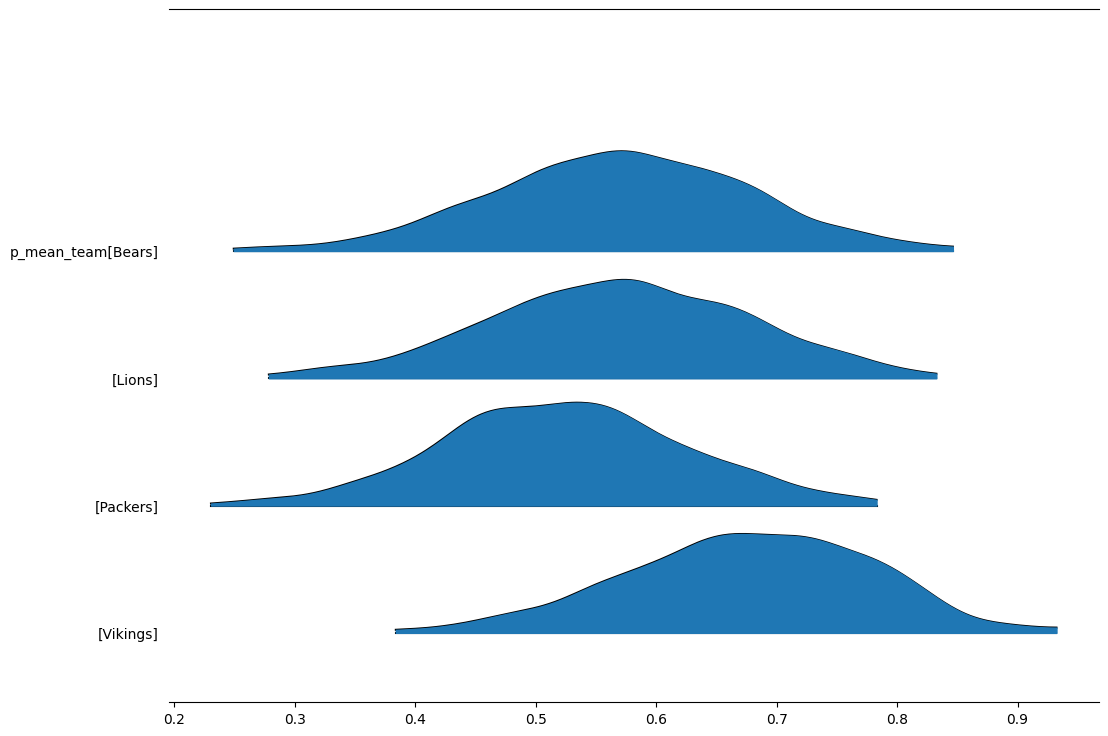

In [7]:
axes = az.plot_forest(idata_nh, kind="ridgeplot",
                      var_names='p_mean_team',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

I chose half normal distributions for my priors because I wanted them to be only positive and still have that normal shape.

The initial model is not great as we can see the observed value is a bit different than the posterior predictive mean. This is because we don't have a lot of data to go off of, and I just wanted to get a preliminary baseline of the data before making more models. In the next iteration, I will include the spread values as a predictor to try and get a more accurate model / posterior predictive mean.

Improved nonhierarchical model (with spread as predictor)

Now we include spread as a predictor:

In [8]:
with pm.Model(coords=team_coords) as nfl_model_nh2:

    intercept = pm.Normal('intercept', mu=0, sigma=5, dims="teams")
    beta_spread = pm.Normal('beta_spread', mu=0, sigma=1, dims="teams")
    logit_p = intercept[team_index] + beta_spread[team_index] * nfl_data['spread']
    p = pm.math.sigmoid(logit_p)

    y = pm.Bernoulli('y', p=p, observed=nfl_data['cover'])

    idata_nh2 = pm.sample(target_accept=0.95, tune=2000)

Output()

Output()

<Axes: xlabel='y'>

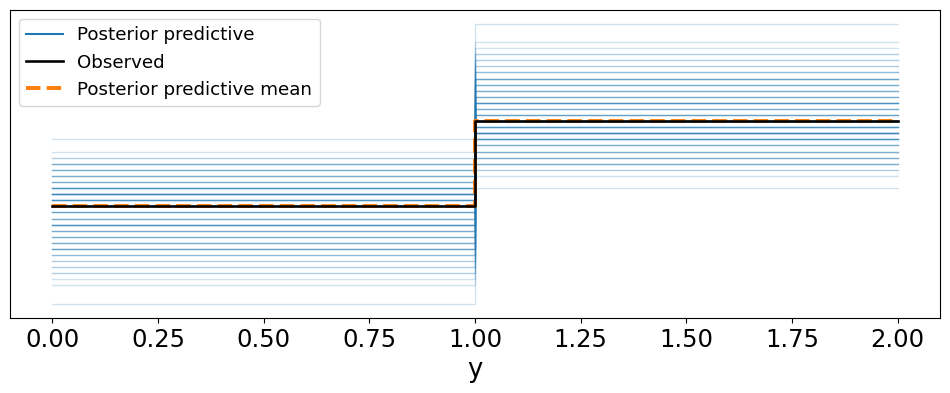

In [9]:
ppc_nh2 = pm.sample_posterior_predictive(idata_nh2, model=nfl_model_nh2, extend_inferencedata=True)
az.plot_ppc(ppc_nh2, num_pp_samples=100, figsize=(12, 4))

We can see that the posterior predictive mean in this model fits the observed data much better.

**Part IV: Hierarchical Models**

Hierarchical models allow teams to share information, which can improve estimates for teams with fewer games or extreme outcomes.

I've done the best I can to model the data with nonhierarchical models. Let's try hierarchical models now, which have hyperpriors and assume that there is dependence between groups.

Simple hierarchical model:

In [15]:
with pm.Model(coords=team_coords) as nfl_model_h:

    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=5)
    sigma_intercept = pm.HalfNormal('sigma_intercept', sigma=3)

    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1, dims="teams")
    intercept = pm.Deterministic('intercept', mu_intercept + sigma_intercept * intercept_raw)

    p = pm.math.sigmoid(intercept[team_index])
    y = pm.Bernoulli('y', p=p, observed=nfl_data['cover'])

    idata_h = pm.sample(draws=4000, tune=5000, target_accept=0.99, chains=4)

Output()

Output()

<Axes: xlabel='y'>

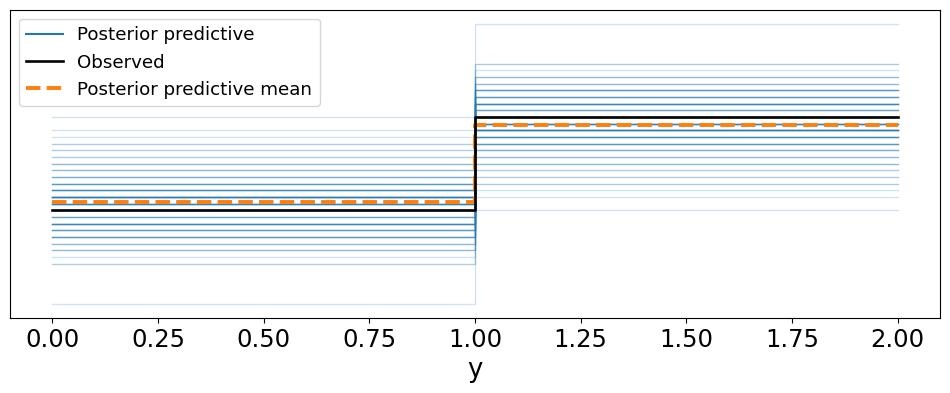

In [14]:
ppc_nh2 = pm.sample_posterior_predictive(idata_nh, model=nfl_model_nh2, extend_inferencedata=True)
az.plot_ppc(ppc_nh2, num_pp_samples=100, figsize=(12, 4))

Hierarchical model with spread as predictor:

In [16]:
with pm.Model(coords=team_coords) as nfl_model_h2:

    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=5)
    sigma_intercept = pm.HalfNormal('sigma_intercept', sigma=3)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)

    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1, dims="teams")
    intercept = pm.Deterministic('intercept', mu_intercept + sigma_intercept * intercept_raw)

    beta_spread_raw = pm.Normal('beta_spread_raw', mu=0, sigma=1, dims="teams")
    beta_spread = pm.Deterministic('beta_spread', mu_beta + sigma_beta * beta_spread_raw)

    logit_p = intercept[team_index] + beta_spread[team_index] * nfl_data['spread']
    p = pm.math.sigmoid(logit_p)

    y = pm.Bernoulli('y', p=p, observed=nfl_data['cover'])

    idata_h2 = pm.sample(draws=3000, tune=4000, target_accept=0.99, chains=4)

Output()

Output()

<Axes: xlabel='y'>

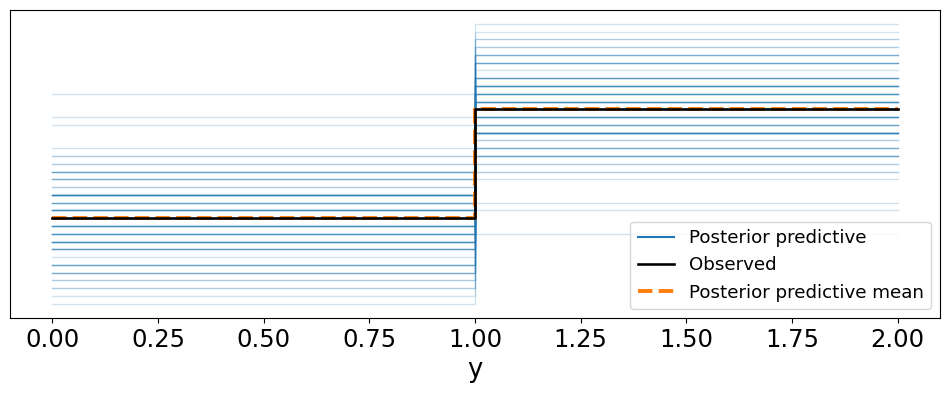

In [17]:
ppc_nh2 = pm.sample_posterior_predictive(idata_nh2, model=nfl_model_nh2, extend_inferencedata=True)
az.plot_ppc(ppc_nh2, num_pp_samples=100, figsize=(12, 4))

array([<Axes: >], dtype=object)

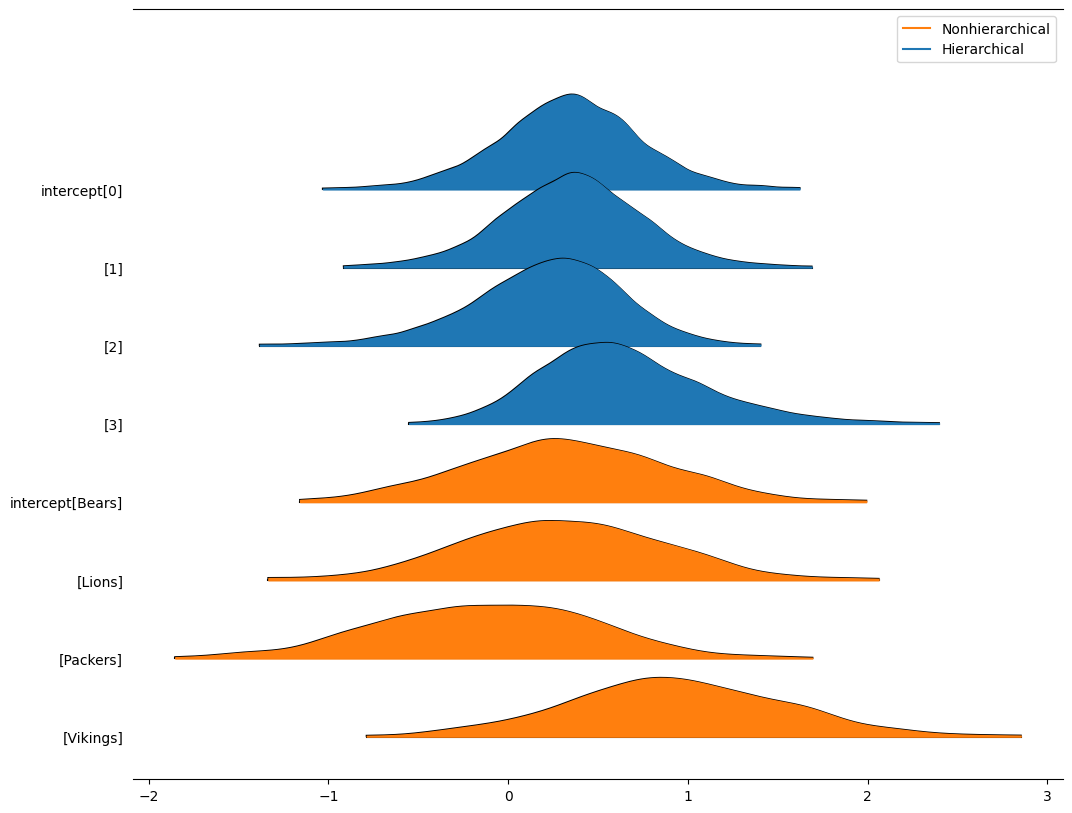

In [12]:
az.plot_forest([idata_h2, idata_nh2], kind="ridgeplot",
               model_names=['Hierarchical', 'Nonhierarchical'],
               var_names='intercept', combined=True, figsize=(12, 10), hdi_prob=0.997)


<xarray.Dataset> Size: 336B
Dimensions:            (beta_spread_dim_0: 4, teams: 4, intercept_dim_0: 4)
Coordinates:
  * beta_spread_dim_0  (beta_spread_dim_0) int64 32B 0 1 2 3
  * teams              (teams) <U7 112B 'Bears' 'Lions' 'Packers' 'Vikings'
  * intercept_dim_0    (intercept_dim_0) int64 32B 0 1 2 3
Data variables:
    beta_spread        (beta_spread_dim_0) float64 32B 1.0 1.0 1.0 1.0
    beta_spread_raw    (teams) float64 32B 1.001 1.001 1.001 1.0
    intercept          (intercept_dim_0) float64 32B 1.0 1.0 1.0 0.9999
    intercept_raw      (teams) float64 32B 1.001 1.0 1.0 1.0
    mu_beta            float64 8B 1.001
    mu_intercept       float64 8B 1.0
    sigma_beta         float64 8B 1.002
    sigma_intercept    float64 8B 1.0

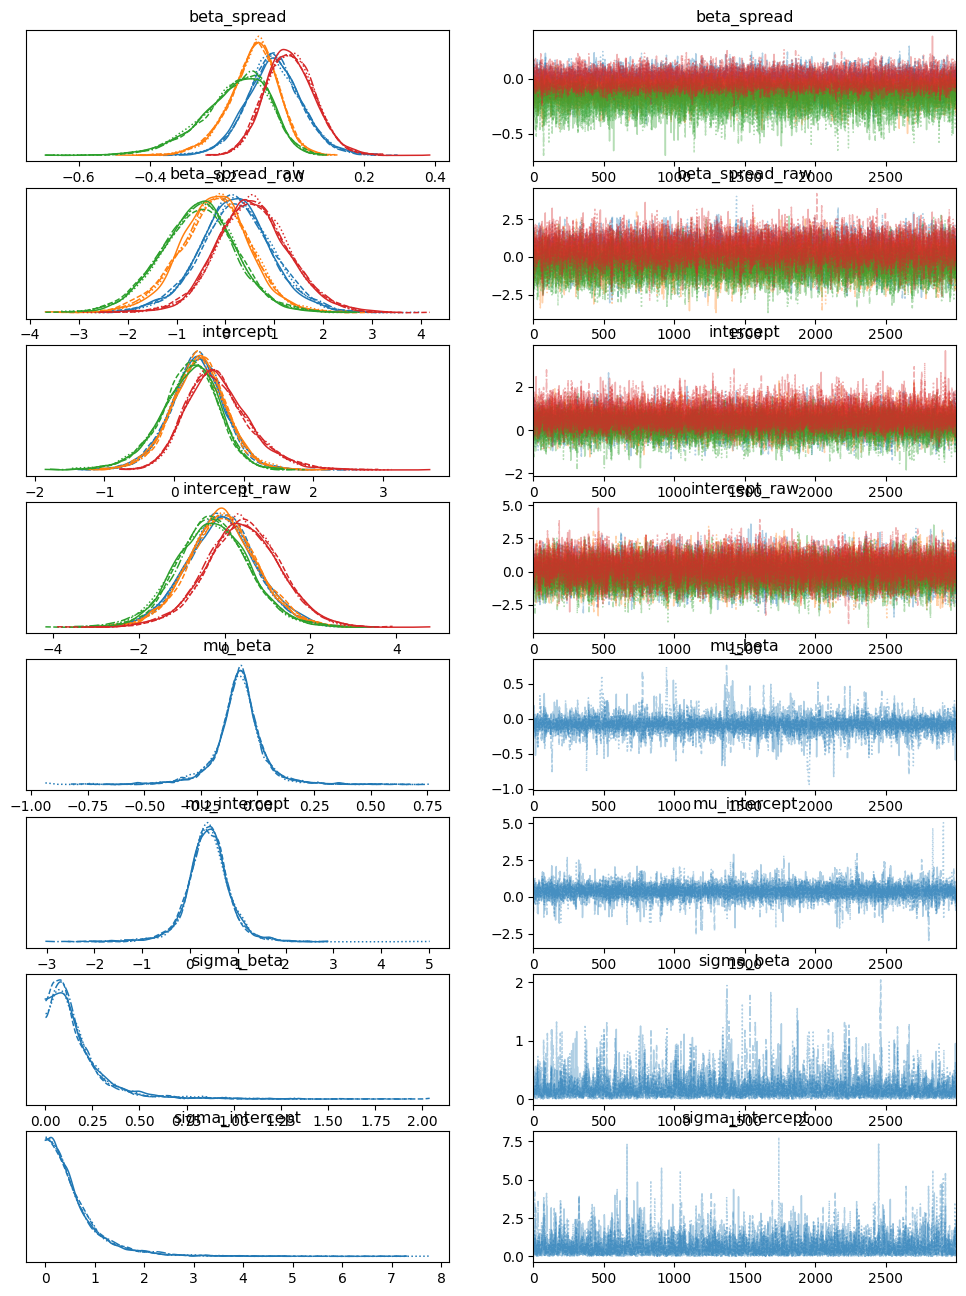

In [13]:
az.plot_trace(idata_h2)
az.rhat(idata_h2)

The amplitudes of the distributions in each of the graps are pretty similar, so this model is good enough.

Here, the team-specific intercepts are not entirely independent. They are drawn from a common 'hyperprior' distribution (governed by `mu_intercept` and `sigma_intercept`). This induces a phenomenon called **shrinkage**. What you should observe in the plot is that the posterior distributions for individual team intercepts in the hierarchical model are 'shrunk' towards the overall mean (`mu_intercept`). This is particularly noticeable for teams with fewer data points or more extreme non-hierarchical estimates. Their hierarchical estimates will be pulled closer to the average across all teams. This shrinkage effect is a one of the biggest advantages of hierarchical modeling since it regularizes the estimates, making them more robust and preventing overfitting to sparse data for individual groups.

^I asked Gemini to explain this part to me.